# Playing with Coronavirus Timeseries

- https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset


### RESOURCES FOR FUTURE
- RAFAEL STUDY GROUP FOR MAKING A MAP
    - https://www.youtube.com/watch?v=MAhK7NHXEOg&feature=emb_logo
    - https://github.com/erdosn/additional-topic-plotly

In [1]:
import os,glob,sys
import re

In [2]:
!pip install -U fsds
from fsds.imports import *

fsds v0.2.15 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


# Function-izing Processing

1. `download_coronavirus_data(fpath='New Data/)` 
2. `1oad_raw_df(filepaths[4])`
3. `get_and_clean_US`
4. `set_datetime_index`

In [3]:
# ## Determine if dataset is downloaded via Kaggle CLI
# import os
# from zipfile import ZipFile


# if DOWNLOAD:
#     !pip install kaggle --upgrade

#     cmd = 'kaggle datasets download -d sudalairajkumar/novel-corona-virus-2019-dataset'
#     os.system(cmd)
#     print('Downloaded dataset Zipfie, extracting...')
#     with ZipFile('novel-corona-virus-2019-dataset.zip') as file:
#         file.extractall()

# #     display( os.listdir())

# os.listdir()

def download_coronavirus_data(path='New Data/',verbose=False):
    """Installs the Kaggle Command Line Interface to clone dataset.
    Then extracts dataset to specified path and displays name of main file.
    Args:
        path(str): Folder to extract dataset into (must end with a '/')
        
    Returns:
        file_list(list): List of full filepaths to downloaded csv files.
    """
    ## Determine if dataset is downloaded via Kaggle CL
    import os,glob
    from zipfile import ZipFile
    from IPython.display import clear_output
    os.makedirs(path, exist_ok=True)

    ## Install Kaggle 
    !pip install kaggle --upgrade
    clear_output()
    
    ## Run Kaggle Command 
    cmd = 'kaggle datasets download -d sudalairajkumar/novel-corona-virus-2019-dataset'
    os.system(cmd)
    
    ## Extract ZipFile
    print(f'Downloaded dataset Zipfie, extracting to {path}...')
    with ZipFile('novel-corona-virus-2019-dataset.zip') as file:
        file.extractall(path)
    
    
    ## Get list of all csvs
    print('[i] Extraction Complete.')    
    file_list = glob.glob(path+"*.csv")
    
    
    ## Find main df 
    main_file = [file for file in file_list if 'covid_19_data.csv' in file]
    if verbose:
        print(f"[i] The main file name is {main_file}")
    return main_file[0] #file_list[index]

In [4]:
DOWNLOAD = True

if DOWNLOAD:
    main_file = download_coronavirus_data()
    print('\n\n[i] Success. Downloaded dataset from kaggle...')

else:
    print('Using pre-existing data')

Downloaded dataset Zipfie, extracting to New Data/...
[i] Extraction Complete.


[i] Success. Downloaded dataset from kaggle...


In [5]:
main_file

'New Data/covid_19_data.csv'

## Main Dataset - Get US States

In [6]:
# df = pd.read_csv('covid_19_data.csv',#index_col=0,
#                  parse_dates=['ObservationDate','Last Update'])
# df.drop(['Last Update',
#          'SNo'],axis=1,inplace=True)
# df.rename({'ObservationDate':'Date'},axis=1,inplace=True)

# # Countries in the dataset
# print(f"There are {len(df['Country/Region'].unique())} countries in the datatset")
# df

### def `load_raw_df`

In [7]:
def load_raw_df(fpath,kws={},verbose=True):
    """Performs most basic of preprocessing, including renaming date column to 
    Date and dropping 'Last Update', and 'SNo' columns"""
    
    ## Default Kws
    read_kws = dict(parse_dates=['ObservationDate','Last Update'])
    
    ## Add User kws
    read_kws = {**read_kws,**kws}
    
    if verbose:
        print(f"[i] Loading {fpath} with read_csv kws:",end='')
        display(read_kws)
        
    df = pd.read_csv(fpath,**read_kws)
    
    ## Drop unwated columns
    df.drop(['Last Update',
             'SNo'],axis=1,inplace=True)

    ## Rename Date columns
    df.rename({'ObservationDate':'Date'},axis=1,inplace=True)
    
    ## Display some info 
    if verbose:
        display(df.head())
        # Countries in the dataset
        print(f"[i] There are {len(df['Country/Region'].unique())} countries in the datatset")
        
        ## Get first and last date
        start_ts = df["Date"].loc[df['Date'].idxmin()].strftime('%m-%d-%Y')
        end_ts = df["Date"].loc[df['Date'].idxmax()].strftime('%m-%d-%Y')
        # DF['Date'].idxmin(), DF['Date'].idxmax()
        print(f"[i] Dates Covered:\n\tFrom {start_ts} to {end_ts}")

    return df

In [8]:
raw_df = load_raw_df(main_file)

[i] Loading New Data/covid_19_data.csv with read_csv kws:

{'parse_dates': ['ObservationDate', 'Last Update']}

,Date,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,0.0,0.0,0.0


[i] There are 223 countries in the datatset
[i] Dates Covered:
	From 01-22-2020 to 06-20-2020


### def `set_datetime_index`

In [9]:
def set_datetime_index(df_,col='Date'):#,drop_old=False):
    df = df_.copy()
    df[col] = pd.to_datetime(df[col],infer_datetime_format=True)
    df.set_index(df[col],drop=True,inplace=True)
    if col in df.columns:
        df.drop(columns=col,inplace=True)
    return df#, inplace=True)


### def `get_and_clean_US`

In [10]:
def get_and_clean_US(df,save_as = 'JMI_us_states.csv',make_date_index=True):
    """Takes raw df loaded and extracts United States and processes
    all state names to create new abbreviation column 'state'.
    """
    ## Get only US
    df_us = df.groupby('Country/Region').get_group('US').copy() 
    
    # REPLACE STATE NAMES
    # https://raw.githubusercontent.com/jirvingphd/List-of-US-States/master/states.csv
    try:
        state_url = 'https://raw.githubusercontent.com/jirvingphd/List-of-US-States/master/states.csv'
        state_lookup = pd.read_csv(state_url)
        state_lookup.to_csv('united_states_abbreviations.csv',index=False)
    except:
        print('Error downloading state lookup csv. Using local copy')
        state_lookup.read_csv('united_states_abbreviations.csv')
    
    ## Make renaming dict for states
    STATE_DICT = dict(zip(state_lookup['State'],state_lookup['Abbreviation']))
    STATE_DICT.update({'Chicago':'IL',
                      'Puerto Rico':'PR',
                      'Virgin Islands':'VI',
                      'United States Virgin Islands':'VI'})

    ## Separately Process Rows that contain a city, state 
    df_city_states = df_us[df_us['Province/State'].str.contains(',')]
    
    
    ## Finding City Abbreviations in city_states
    import re
    state_expr = re.compile(r"[A-Z\.]{2,4}")
    df_city_states['state'] = df_city_states['Province/State'].apply(state_expr.findall)
    df_city_states = df_city_states.explode('state')


    ## Seperately process Rows that do not contain a city,state
    df_states = df_us[~df_us['Province/State'].str.contains(',')]
    df_states['state'] =  df_states['Province/State'].map(STATE_DICT)

    ## Combining data frame back together
    df = pd.concat([df_states,df_city_states]).sort_index()
    df = df.dropna(subset=['state'])
    
    
    if len(save_as)>0:
        print(f'[i] Saving final df as {save_as}')
        df.to_csv(save_as,index=False)
        
    if make_date_index:
        df = set_datetime_index(df)
    return df

In [11]:
df = get_and_clean_US(raw_df)
df

[i] Saving final df as JMI_us_states.csv


,Province/State,Country/Region,Confirmed,Deaths,Recovered,state
Date,,,,,,
2020-01-22,Washington,US,1.0,0.0,0.0,WA
2020-01-23,Washington,US,1.0,0.0,0.0,WA
2020-01-24,Washington,US,1.0,0.0,0.0,WA
2020-01-24,Chicago,US,1.0,0.0,0.0,IL
2020-01-25,Washington,US,1.0,0.0,0.0,WA
...,...,...,...,...,...,...
2020-06-20,Virginia,US,57443.0,1607.0,0.0,VA
2020-06-20,Washington,US,28225.0,1265.0,0.0,WA
2020-06-20,West Virginia,US,2500.0,88.0,0.0,WV


### Testing workflow so far

In [12]:
main_file = download_coronavirus_data()
raw_df = load_raw_df(main_file)
df = get_and_clean_US(raw_df)
df.head()

Downloaded dataset Zipfie, extracting to New Data/...
[i] Extraction Complete.
[i] Loading New Data/covid_19_data.csv with read_csv kws:

{'parse_dates': ['ObservationDate', 'Last Update']}

,Date,Province/State,Country/Region,Confirmed,Deaths,Recovered
0,2020-01-22,Anhui,Mainland China,1.0,0.0,0.0
1,2020-01-22,Beijing,Mainland China,14.0,0.0,0.0
2,2020-01-22,Chongqing,Mainland China,6.0,0.0,0.0
3,2020-01-22,Fujian,Mainland China,1.0,0.0,0.0
4,2020-01-22,Gansu,Mainland China,0.0,0.0,0.0


[i] There are 223 countries in the datatset
[i] Dates Covered:
	From 01-22-2020 to 06-20-2020
[i] Saving final df as JMI_us_states.csv


,Province/State,Country/Region,Confirmed,Deaths,Recovered,state
Date,,,,,,
2020-01-22,Washington,US,1.0,0.0,0.0,WA
2020-01-23,Washington,US,1.0,0.0,0.0,WA
2020-01-24,Washington,US,1.0,0.0,0.0,WA
2020-01-24,Chicago,US,1.0,0.0,0.0,IL
2020-01-25,Washington,US,1.0,0.0,0.0,WA


In [13]:
df.head()

,Province/State,Country/Region,Confirmed,Deaths,Recovered,state
Date,,,,,,
2020-01-22,Washington,US,1.0,0.0,0.0,WA
2020-01-23,Washington,US,1.0,0.0,0.0,WA
2020-01-24,Washington,US,1.0,0.0,0.0,WA
2020-01-24,Chicago,US,1.0,0.0,0.0,IL
2020-01-25,Washington,US,1.0,0.0,0.0,WA


In [14]:
## Report Total Cases
total_cases = df.groupby('state').sum()
total_cases.sort_values('Deaths',0,0).head(20).style.bar(['Deaths','Confirmed'])

,Confirmed,Deaths,Recovered
state,,,
NY,2.50345e+07,1.87456e+06,0
NJ,1.0058e+07,661297,2
MA,5.67798e+06,362647,19
MI,3.70004e+06,327118,5
PA,4.46429e+06,284715,0
IL,6.24406e+06,279115,76
CA,6.22327e+06,226370,76
CT,2.49282e+06,213483,0
LA,2.60626e+06,169139,0


## PAUSE 06/21 - How to use this new workflow next?

In [15]:
# df = pd.read_csv('JMI_us_states.csv',
#                   parse_dates=['Date'],index_col='Date',
#                   infer_datetime_format=True)
# df.head()

In [16]:
df.groupby('state').resample('d').sum()

Confirmed  Deaths  Recovered
state Date                                    
AK    2020-03-10        0.0     0.0        0.0
      2020-03-11        0.0     0.0        0.0
      2020-03-12        0.0     0.0        0.0
      2020-03-13        1.0     0.0        0.0
      2020-03-14        0.0     0.0        0.0
...                     ...     ...        ...
WY    2020-06-16     1089.0    18.0        0.0
      2020-06-17     1114.0    18.0        0.0
      2020-06-18     1144.0    18.0        0.0
      2020-06-19     1173.0    20.0        0.0
      2020-06-20     1179.0    20.0        0.0

[5869 rows x 3 columns]

In [17]:
### Get daily stats by state
df2= df.groupby('state').resample('d').sum()
df2

Confirmed  Deaths  Recovered
state Date                                    
AK    2020-03-10        0.0     0.0        0.0
      2020-03-11        0.0     0.0        0.0
      2020-03-12        0.0     0.0        0.0
      2020-03-13        1.0     0.0        0.0
      2020-03-14        0.0     0.0        0.0
...                     ...     ...        ...
WY    2020-06-16     1089.0    18.0        0.0
      2020-06-17     1114.0    18.0        0.0
      2020-06-18     1144.0    18.0        0.0
      2020-06-19     1173.0    20.0        0.0
      2020-06-20     1179.0    20.0        0.0

[5869 rows x 3 columns]

In [18]:
df.groupby(['state','Date']).resample("D").sum()

Confirmed  Deaths  Recovered
state Date       Date                                    
AK    2020-03-10 2020-03-10        0.0     0.0        0.0
      2020-03-11 2020-03-11        0.0     0.0        0.0
      2020-03-12 2020-03-12        0.0     0.0        0.0
      2020-03-13 2020-03-13        1.0     0.0        0.0
      2020-03-15 2020-03-15        1.0     0.0        0.0
...                                ...     ...        ...
WY    2020-06-16 2020-06-16     1089.0    18.0        0.0
      2020-06-17 2020-06-17     1114.0    18.0        0.0
      2020-06-18 2020-06-18     1144.0    18.0        0.0
      2020-06-19 2020-06-19     1173.0    20.0        0.0
      2020-06-20 2020-06-20     1179.0    20.0        0.0

[5868 rows x 3 columns]

In [19]:
df.index

DatetimeIndex(['2020-01-22', '2020-01-23', '2020-01-24', '2020-01-24',
               '2020-01-25', '2020-01-25', '2020-01-26', '2020-01-26',
               '2020-01-26', '2020-01-26',
               ...
               '2020-06-20', '2020-06-20', '2020-06-20', '2020-06-20',
               '2020-06-20', '2020-06-20', '2020-06-20', '2020-06-20',
               '2020-06-20', '2020-06-20'],
              dtype='datetime64[ns]', name='Date', length=6330, freq=None)

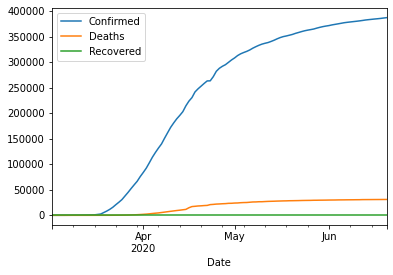

In [20]:
state_df = df.groupby('state').get_group('NY').resample('D').sum()
state_df.plot()

### `def get_state_ts`

In [21]:
def get_state_ts_new(df, state_name,
                     group_col='state', ts_col=None,
                     freq='D', agg_func='sum'):
    
    ## Get state_df group
    state_df = df.groupby(group_col).get_group(state_name)#.resample(freq).agg(agg)
    
    ## Resample and aggregate state data
    state_df = state_df.resample(freq).agg(agg_func)
    
    
    ## Get and Rename Sum Cols 
    orig_cols = state_df.columns

    ## Create Renamed Sum columns
    for col in orig_cols:
        state_df[f"{state_name} - {col}"] = state_df[col]
      
    ## Drop original cols
    state_df.drop(orig_cols,axis=1,inplace=True)
    
    if ts_col is not None:
        ts_cols_selected = [col for col in state_df.columns if ts_col in col]
        state_df = state_df[ts_cols_selected]
    
    
    
    return state_df

In [22]:
state_df = get_state_ts_new(df,"NY")
state_df

,NY - Confirmed,NY - Deaths,NY - Recovered
Date,,,
2020-03-02,1.0,0.0,0.0
2020-03-03,2.0,0.0,0.0
2020-03-04,11.0,0.0,0.0
2020-03-05,23.0,0.0,0.0
2020-03-06,36.0,0.0,0.0
...,...,...,...
2020-06-16,384575.0,30909.0,0.0
2020-06-17,385142.0,30939.0,0.0
2020-06-18,385760.0,30974.0,0.0


In [23]:
state_df.index

DatetimeIndex(['2020-03-02', '2020-03-03', '2020-03-04', '2020-03-05',
               '2020-03-06', '2020-03-07', '2020-03-08', '2020-03-09',
               '2020-03-10', '2020-03-11',
               ...
               '2020-06-11', '2020-06-12', '2020-06-13', '2020-06-14',
               '2020-06-15', '2020-06-16', '2020-06-17', '2020-06-18',
               '2020-06-19', '2020-06-20'],
              dtype='datetime64[ns]', name='Date', length=111, freq='D')

In [24]:
state_df.iplot(theme='solar')

#### Need to decide what form to leave df in for plotting functions

In [25]:
# def get_state_ts(df, state_name,
#                  group_col='state',
#                  ts_col=None,resample=False,agg='sum',dt_index='Date'):#, ts_col='Cases'):
#     """"Separates a state_name/group from the group_col of df
#     Returns a resampled aggregate timeseries"""
    
#     ts = df.groupby(group_col).get_group(state_name)
    
#     # ts.set_index('date',inplace=True)
#     ts = ts.reset_index(drop=False).set_index(dt_index)
    
#     if resample:
#         ts = ts.resample('d').agg(agg)
#         ts['state'] = state_name
        
#     ## Return specific columns if specificed
#     if ts_col is not None:
#         return ts[ts_col]#.rename(f"{ts_col.name}-{state_name}")
#     else:
#         return ts

In [26]:
    
# ts_NY = get_state_ts(df,'NY',
#                   ts_col=['Confirmed',"Deaths","Recovered"],resample=True)
# display(ts_NY.head())
# for col in['Confirmed','Deaths','Recovered']:
#     ts_NY[col+'-Cumulative'] = ts_NY[col].cumsum()
# NY = ts_NY.reset_index()
# NY

In [27]:
# import plotly.express as px
# px.line(NY,x='Day',y='Confirmed-Cumulative')
# px.line(NY,x='Day',y='Confirmed')

In [28]:
# get_state_ts(df,'NY',ts_col='Confirmed')#.plot()

### Get all states in a dict

In [29]:
state_list=df['state'].unique()
print(len(state_list))
state_list

55


array(['WA', 'IL', 'CA', 'AZ', 'MA', 'WI', 'TX', 'NE', 'OR', 'RI', 'NH',
       'FL', 'NY', 'GA', 'NC', 'NJ', 'NV', 'TN', 'MD', 'CO', 'PA', 'KY',
       'IN', 'MN', 'CT', 'SC', 'UT', 'HI', 'OK', 'VA', 'D.C.', 'KS', 'MO',
       'VT', 'IA', 'LA', 'DC', 'OH', 'AK', 'AR', 'DE', 'ID', 'ME', 'MI',
       'MS', 'MT', 'NM', 'ND', 'SD', 'WV', 'WY', 'AL', 'PR', 'U.S.', 'VI'],
      dtype=object)

In [36]:
STATES = {}
for state in state_list:
    STATES[state] = get_state_ts_new(df,state)

STATES.keys()

dict_keys(['WA', 'IL', 'CA', 'AZ', 'MA', 'WI', 'TX', 'NE', 'OR', 'RI', 'NH', 'FL', 'NY', 'GA', 'NC', 'NJ', 'NV', 'TN', 'MD', 'CO', 'PA', 'KY', 'IN', 'MN', 'CT', 'SC', 'UT', 'HI', 'OK', 'VA', 'D.C.', 'KS', 'MO', 'VT', 'IA', 'LA', 'DC', 'OH', 'AK', 'AR', 'DE', 'ID', 'ME', 'MI', 'MS', 'MT', 'NM', 'ND', 'SD', 'WV', 'WY', 'AL', 'PR', 'U.S.', 'VI'])

In [37]:
# !pip install -U plotly
STATES['MD']

,MD - Confirmed,MD - Deaths,MD - Recovered
Date,,,
2020-03-06,3.0,0.0,0.0
2020-03-07,3.0,0.0,0.0
2020-03-08,5.0,0.0,0.0
2020-03-09,5.0,0.0,0.0
2020-03-10,8.0,0.0,0.0
...,...,...,...
2020-06-16,62409.0,2982.0,0.0
2020-06-17,62969.0,2996.0,0.0
2020-06-18,63229.0,3016.0,0.0


### Plot selected states and columns

In [32]:
### Define states and columns to plot
plot_states = ['NY','MD','CA']
plot_cols = ['Confirmed']


## Make empty list for states to concat
concat_dfs = []

# Grab each state's df
for state in plot_states:
    dfs = STATES[state]
    
    ## for each plot_cols, find all columns that contain that col name
    for plot_col in plot_cols:
        concat_dfs.append(dfs[[col for col in dfs.columns if plot_col in col]])

        
## Concatenate final dfs
plot_df = pd.concat(concat_dfs,axis=1)#[STATES[s] for s in plot_states],axis=1).iplot()

## Plot concatenated dfs
pfig = plot_df.iplot(theme='solar',asFigure=True)
pfig

In [40]:
def plot_states(df, state_list, plot_cols = ['Confirmed']):
    concat_dfs = []  
    STATES = {}
    for state in state_list:
        # Grab each state's df and save to STATES
        dfs = get_state_ts_new(df,state)
        STATES[state] = dfs

        ## for each plot_cols, find all columns that contain that col name
        for plot_col in plot_cols:
            concat_dfs.append(dfs[[col for col in dfs.columns if plot_col in col]])


    ## Concatenate final dfs
    plot_df = pd.concat(concat_dfs,axis=1)#[STATES[s] for s in plot_states],axis=1).iplot()

    ## Plot concatenated dfs
    pfig = plot_df.iplot(theme='solar',asFigure=True)
    return pfig

In [43]:
pfig = plot_states(df,['NY','MD','KY','CA','FL'])
pfig

In [33]:
# def iplot_corona(df_,region='US',):
#     if df_.index.freq==None:
#          ts= df_.resample('d').sum()
#     else:
#         ts = df_.copy()

#     pfig = ts.iplot(theme='solar',asFigure=True,
#                     title=f'Coronavirus in {region}',
#                yTitle='# of Cumulative Cases')
#     return pfig
# iplot_corona(STATES['NY'])

####

In [34]:
# def get_and_plot_state(df,state_name='NY',plot=True):
#     state = get_state_ts_new(df,state_name)
#     ts = state.resample('d').sum()
#     if plot:
#         pfig = iplot_corona(ts,state_name)
#         display(pfig)
#     return ts#pfig

# test = get_and_plot_state(df,state_name='NY')
# test

In [35]:
# def plot_states(df, state_list =['NY','MD','CA'], plot_col = 'confirmed'):
#     columns=[f"{state}-{plot_col}" for state in state_list]
#     df_plot = pd.DataFrame()
#     for state in state_list:
#         ts = get_and_plot_state(df,state_name=state,plot=True)
# #         ts.name = f"{state}-{plot_col}"
#         df_plot = pd.concat([df_plot,ts],axis=1)
#     return df_plot
        

# df_plot = plot_states(df)
# df_plot
# # for state in state_list:

# 📕BOOKMARK 06/21

- Making a Dashboard
- Want a plotly figure that will show whatever column (confirmed, deaths,recovered) for whichever states as either cumulative or daily frequency time-series data

## Dashboard

### `def get_state_ts`

In [1]:
def get_state_ts(df, state_name,
                     group_col='state', ts_col=None,
                     freq='D', agg_func='sum'):
    """Take df_us and extracts state's data as then Freq/Aggregation provided"""
    
    ## Get state_df group
    state_df = df.groupby(group_col).get_group(state_name)#.resample(freq).agg(agg)
    
    ## Resample and aggregate state data
    state_df = state_df.resample(freq).agg(agg_func)
    
    
    ## Get and Rename Sum Cols 
    orig_cols = state_df.columns

    ## Create Renamed Sum columns
    for col in orig_cols:
        state_df[f"{state_name} - {col}"] = state_df[col]
      
    ## Drop original cols
    state_df.drop(orig_cols,axis=1,inplace=True)
    
    if ts_col is not None:
        ts_cols_selected = [col for col in state_df.columns if ts_col in col]
        state_df = state_df[ts_cols_selected]

    return state_df

### Making Plot Using pure plotly

In [2]:
df.head()

NameError: name 'df' is not defined

```python
def get_state_ts_app(df, state_name,
                 group_col='state',
                 ts_col=None,resample=False,agg='sum',dt_index='Day'):#, ts_col='Cases'):
    """"Separates a state_name/group from the group_col of df
    Returns a resampled aggregate timeseries"""
    
    ts = df.groupby(group_col).get_group(state_name)
    
    # ts.set_index('date',inplace=True)
    ts = ts.reset_index(drop=False).set_index(dt_index)
    
    if resample:
        ts = ts.resample('d').agg(agg)
        ts['state'] = state_name
        
    ## Return specific columns if specificed
    if ts_col is not None:
        ts = ts[ts_col]#.rename(f"{ts_col.name}-{state_name}")
    if isinstance(ts, pd.Series):
        ts.name = f"{ts_col}-{state_name}"
    return ts

state_dict ={}
for state in ['NY','MD','CA']:
    state_dict[state] = get_state_ts_app(df,state_name=state,resample=True,ts_col='Confirmed')#get_and_plot_state(df,state_name=state)
    ```

In [ ]:
# state_dict['NY']

In [ ]:
# get_state_ts_app(df,state_name=state,resample=True,ts_col='Confirmed')#get_and_plot_state(df,state_name=state)

#### Practice getting all forms of a state's data from df

In [ ]:
state_to_plot = 'NY'
freq = 'D'


## Get Daily Sum, Cum Sum into 1 df for a state
state_df = df.groupby('state').get_group(state_to_plot).resample(freq).sum()
display(state_df.head())

## Get and Rename Sum Cols 
orig_cols = state_df.columns

for col in orig_cols:
    state_df[f"{state_to_plot} - {col}-Sum({freq})"] = state_df[col]

sum_cols = [col for col in state_df.columns if 'Sum' in col]

display(state_df.head())

In [ ]:
state_df[sum_cols].iplot(title='Daily Stats for NY')

In [ ]:
## Create Cumulative columns
for col in orig_cols:
    col_name = f"{state_to_plot} - {col}-Cumulative({freq})"
    state_df[col_name] = state_df[col].cumsum()

cumul_cols = [col for col in state_df.columns if 'Cumulative' in col]
state_df.drop(orig_cols,axis=1,inplace=True)
state_df.head()

In [ ]:
state_df[cumul_cols].iplot(title='Cumulative Stats for Ny')

### def get_state_df_renamed

In [ ]:
### MAKE ABOVE INTO A FUNCTION 
def get_state_df_renamed(df,state_to_plot = 'NY', freq = 'D'):
    
    
    ## Get Daily Sum, Cum Sum into 1 df for a state
    state_df = df.groupby('state').get_group(state_to_plot).resample(freq).sum()

    ## Get and Rename Sum Cols 
    orig_cols = state_df.columns

    ## Create Renamed Sum columns
    for col in orig_cols:
        state_df[f"{state_to_plot} - {col}-Sum({freq})"] = state_df[col]
    ## Save list for future use
    sum_cols = [col for col in state_df.columns if 'Sum' in col]

    ## Create Cumulative columns
    for col in orig_cols:
        col_name = f"{state_to_plot} - {col}-Cumulative({freq})"
        state_df[col_name] = state_df[col].cumsum()
    cumul_cols = [col for col in state_df.columns if 'Cumulative' in col]
    
    ## Drop original cols
    state_df.drop(orig_cols,axis=1,inplace=True)
    
    col_dict = {'sum':sum_cols,'cumulative':cumul_cols}

    return state_df, col_dict

In [ ]:
## Test new function
ny_df,col_dict = get_state_df_renamed(df,'NY',freq='D')
ny_df.head()

In [ ]:
ny_df[col_dict['sum']].iplot()

In [ ]:
# fs.ihelp(get_state_ts)

In [ ]:
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go



In [ ]:
len(STATES.keys())

In [ ]:
go.Figure()

In [ ]:

# pfig = ts.iplot(theme='solar',asFigure=True,
#                 title=f'Coronavirus in {region}',
#            yTitle='# of Cumulative Cases')

In [ ]:
def 

### Making JupyterDash app

In [ ]:
# %conda install -c conda-forge -c plotly jupyter-dash

from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output

In [ ]:
# Build App
app = JupyterDash()
app.layout = html.Div([
    html.H1("Coronavirus Analysis"),
])
app.run_server(mode='inline')

# PRIOR - TIME SERIES

In [ ]:
stop

In [ ]:
# ## KAGGLE DATASET COMMAND LINE VERS
# df = pd.read_csv('2020-03-13/all_sources_metadata_2020-03-13.csv')

# df.head()

In [ ]:
ts_files = glob.glob('time_series*.csv')
ts_files

In [ ]:
## Get the column names from the file name
def clean_name(x,split_on='_19_'):
    name = x.split(split_on)[-1].replace('.csv','')
    return name

col_names = list(map(clean_name,ts_files))
col_names

In [ ]:
files_to_load = dict(zip(col_names,ts_files))
files_to_load

In [ ]:
deaths_df = pd.read_csv(files_to_load['deaths'])
deaths_df

In [ ]:
df_ts_us = deaths_df.groupby('Country/Region').get_group('US')
df_ts_us

In [ ]:
df_US = pd.melt(df_ts_us,id_vars=['Province/State','Country/Region','Lat','Long'], var_name='Day', value_name='Deaths')
df_US

In [ ]:
df = df_US

## Make datetime 
df['datetime'] = pd.to_datetime(df['Day'])

## Set Datetime as index
ts = df.set_index('datetime')['Deaths']
ts.index

In [ ]:
ts.plot()

In [ ]:
# df_US = pd.melt(df_ts_us,id_vars=['Province/State','Country/Region','Lat','Long'], var_name='Day', value_name='confirmed')
df_US["Province/State"].value_counts(dropna=False)

In [ ]:
stop

## OLDER

In [ ]:
## NEW DATA TO LOAD IN
df_ts_dead = pd.read_csv('time_series_covid_19_deaths.csv')
df_ts_recover = pd.read_csv('time_series_covid_19_recovered.csv')
df_ts_conf = pd.read_csv('time_series_covid_19_confirmed.csv')


df_dict = dict(confirmed =df_ts_conf,dead=df_ts_dead,recovered=df_ts_recover)

for k,_df in df_dict.items():
    _df = pd.melt(_df,id_vars=['Province/State','Country/Region','Lat','Long'], var_name='Day', value_name=k)
    _df['Day']= pd.to_datetime(_df['Day'])
    _df.set_index(['Country/Region','Province/State','Day'],inplace=True)
    df_dict[k] = _df#.drop(columns=['Lat','Long'])

df = pd.concat(list(df_dict.values()),axis=1)
df = df.reset_index().set_index("Day")
df.head()

In [ ]:
# df_dict['confirmed'].columns#.loc['Province/State']

In [ ]:


df.head()

## BOOKMARK (old)

In [ ]:
mpl.rcParams['figure.figsize'] = (12,6)

In [ ]:
def get_country_ts(df, country,group_col='Country/Region',ts_col='Cases'):
    ts = df.groupby(group_col).get_group(country )
    # ts.set_index('date',inplace=True)

    if ts_col is not None:
        return ts[ts_col]
    else:
        return ts

In [ ]:
get_country_ts(df,'US',ts_col=None)[['confirmed','dead','recovered']].plot()

In [ ]:
us = get_country_ts(df,'US',ts_col=None)[['confirmed','dead','recovered']].loc['02-15-20':]
us = us.resample('d').sum()#.cumsum().asfreq('d')

In [ ]:
us.plot()

In [ ]:
import plotly.express as px
import plotly.graph_objs as go
import cufflinks as cf
cf.go_offline()


In [ ]:
ts = pd.concat([us,us.index.to_series(name='Plot Date')],axis=1)
pfig = px.line(ts, x='Plot Date',y='dead')
pfig  # (ts, x='Plot Date',y='confirmed')

In [ ]:
pfig = us.iplot(theme='solar',asFigure=True,title='Coronavirus in the US',
               yTitle='# of Cumulative Cases')
pfig

In [ ]:
us_state = df.groupby('Country/Region').get_group('US')
us_state['Province/State'].value_counts()

# OLDEST CODE BELOW

In [ ]:
df_ts_conf = pd.read_csv('novel-corona-virus-2019-dataset/time_series_covid_19_confirmed.csv')
df_ts_conf

In [ ]:
df = pd.melt(df_ts_conf,id_vars=['Province/State','Country/Region','Lat','Long'], var_name='Day', value_name='Cases')
df

In [ ]:
df['date'] = pd.to_datetime(df['Day'])


In [ ]:
sorted(df['Country/Region'].unique())

In [ ]:
TS = {}
for country in df.groupby('Country/Region').groups:
    ts_temp = df.groupby('Country/Region').get_group(country)
    ts_temp.set_index('date',inplace=True)
    TS[country] =ts_temp

In [ ]:
def get_country_ts(df, country,group_col='Country/Region',ts_col='Cases'):
    ts = df.groupby(group_col).get_group(country )
    ts.set_index('date',inplace=True)

    if ts_col is not None:
        return ts[ts_col]
    else:
        return tsx
usa = get_country_ts(df,'US')
usa




In [ ]:

usa.iloc[-10:]

In [ ]:
italy = get_country_ts(df,'Italy')
italy.plot()

In [ ]:
def get_country_cum_ts(df, group='US'):
    US = df.groupby('Country/Region').get_group(group)
    US.set_index('date',inplace=True)
    ts_us = US.drop(columns=['Province/State','Day','Country/Region'])['Cases'].cumsum()#.plot()
    return ts_us

In [ ]:
ts_it = get_country_cum_ts(df,'Italy')
ts_us = get_country_cum_ts(df,'US')
ts_ch = get_country_cum_ts(df,'China')
ts_ko = get_country_cum_ts(df,'Korea, South')
ts_it.plot(label='Italty')
ts_us.plot(label='US')
plt.legend()

In [ ]:
ts_it.head()

In [ ]:

# ts_df = pd.concat([ts_us,ts_it,ts_ch,ts_ko],axis=1)
# ts_df.plot(subplots=True)

In [ ]:
# US = df.groupby('Country/Region').get_group('US')
# US.set_index('date',inplace=True)
# ts_us = US.drop(columns=['Province/State','Day','Country/Region'])['Cases'].cumsum()#.plot()
# ts_us.plot()

In [ ]:
# IT = df.groupby('Country/Region').get_group('Italy')
# IT.set_index('date',inplace=True)
# ts_it = IT.drop(columns=['Province/State','Day','Country/Region'])['Cases'].cumsum()#.plot()

In [ ]:
# pd.concat

In [ ]:
ts_it.plot(label='Italy')
ts_us.plot(label='US')
# ts_ch.plot(label='China')
plt.legend()

In [ ]:
fig, ax = plt.subplots()
for country in TS:
    TS[country]['Cases'].cumsum().plot(label=country,ax=ax)

ax.legend(bbox_to_anchor=(1.1, 1.05))


# plt.legend()